In [1]:
###########################
# convert amodal to our formulation
###########################
# load the autoreload extension
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

import sys
sys.path.append("..")

from modal.amodal import Amodal
import matplotlib.pyplot as plt
import numpy as np
import random,pickle
import cv2,os,json
from skimage import morphology
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [107]:
#use number to label areas, 2**i = visual areas index for amodal i ,2**(32+i) = invisual mask index for amodal i

def reLayerMask(mask_amodal, mask_invis):
    mask_zeros = np.zeros(mask_amodal[0].shape).astype('bool')
    labal = np.zeros(mask_amodal[0].shape).astype('uint64')
    for i in range(len(mask_amodal)):
        if i >= 32:
            continue
        if len(mask_invis[i]):
            invis = mask_invis[i] > 0
            labal[invis] |= 1 << (i + 32)
            mask_vis = mask_amodal[i] - mask_invis[i]
        else:
            mask_vis = mask_amodal[i]

        labal[mask_vis > 0] |= 1 << i

    labal = remove_small_path(labal, min_size=64)
    return labal


def remove_small_path(labal, min_size=64):
    color = np.unique(labal)
    for i in range(len(color)):
        mask = (labal == color[i])
        mask_new = morphology.remove_small_objects(mask, min_size=min_size)
        if not mask_new.max():
            labal[mask] = 0
    return labal


def get_image_labals(labal):
    labal_ids = np.unique(labal)
    if labal_ids[0] == 0:
        labal_ids = np.delete(labal_ids, 0)
    return labal_ids


# id start from 0
def objectID_to_masks(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask_vis, mask_invis = [], []
    index_vis = ((labal_ids >> id) & 1 == 1).nonzero()
    index_invis = ((labal_ids >> np.uint64(id + 32)) & 1 == 1).nonzero()

    for items in index_vis:
        for i in range(items.size):
            mask_vis.append(labal == labal_ids[items[i]])
    for items in index_invis:
        for i in range(items.size):
            mask_invis.append(labal == labal_ids[items[i]])

    return (mask_vis, index_vis, mask_invis, index_invis)


# id start from 0, id<0 return all masks
def maskID_to_mask(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask = []
    if id < 0:
        for items in labal_ids:
            mask.append(labal == items)
        return mask
    else:
        return labal == labal_ids[id]


def number_to_index(labal_id):
    bin_index, objectID = 0, []
    while labal_id:
        if labal_id & np.uint64(1):
            return bin_index
        bin_index += 1
        labal_id = labal_id >> np.uint64(1)



def remove_last_one(number, depth):
    while number and depth:
        number = np.bitwise_and(number,np.uint64(number - 1))
        depth -= 1
    return number


# id start from 0
# return vis object id invis layer 1 - n
def maskID_to_objectIDs(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    labal_id = labal_ids[id]

    vis = (labal_id << np.uint64(32)) >> np.uint64(32)  # remove highest 32 bit
    invis = labal_id >> np.uint64(32)  ## remove lowest 32 bit

    object_id_vis = number_to_index(vis)
    object_id_invis = number_to_index(invis)
    object_id_vis.extend(object_id_invis)
    return object_id_vis


def layer_to_mask(labal, depth, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    mask, objectID = [], []
    vis = (labal_ids << np.uint64(32)) >> np.uint64(32)
    if 0 == depth:
        for i in range(len(vis)):
            mask.append(maskID_to_mask(labal, i))
            objectID.append(number_to_index(vis[i]))
        return (mask, objectID)

    else:
        # find (depth)th 1 from left to right, is exist have depth layer else not
        depth -= 1
        labal_inds = []
        invis = labal_ids >> np.uint64(32)
        for i in range(len(invis)):#len(invis)
            new_labal = remove_last_one(invis[i], depth)
                
            if new_labal:

                object_id = number_to_index(new_labal)#the first vis object index
                _, _, mask_invis, index_invis =objectID_to_masks(labal, object_id, labal_ids)
                

                for k in range(len(index_invis)):
                    labal_ind = labal_ids[index_invis[0][k]] 

                    new_labal_2 = remove_last_one(labal_ind >> np.uint64(32),depth)
                    if new_labal_2 and object_id == number_to_index(new_labal_2):
                        if labal_ind not in labal_inds:
                            labal_inds.append(labal_ind)
                            mask.append(mask_invis[k])
                            objectID.append(object_id)

        return (mask, objectID)

In [2]:
## file converter D2S TO COCO
image_ids = []
ann_file = '../datasets/D2S/annotations/D2S_amodal_training_rot0.json'
D2S = COCO(ann_file)
for ann in D2S.dataset['annotations']:
    image_ids.append(ann['image_id'])
image_id_list = np.unique(image_ids)

annotations = []
for i,img_id in enumerate(image_id_list):
    region,new_ann,occl_depth = [],{},[]
    index = np.where(img_id == image_ids)
    for j in index[0]:  
        ann = D2S.dataset['annotations'][j]
        region.append(ann)

    region = sorted(region, key=lambda reg : reg['occl_depth'])
    new_ann['size'] = len(region)
    new_ann['id'] = i
    new_ann['regions'] = region
    new_ann['image_id'] = img_id
    annotations.append(new_ann)
D2S.dataset['annotations'] = annotations

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: '../datasets/D2S/annotations/D2S_amodal_training_rot0.json'

In [2]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

filename = '../datasets/D2S/annotations/COCO_amodal_val2014.json'
# with open(filename, 'w') as outfile:
#     json.dump(D2S.dataset, outfile, cls=MyEncoder)
amodal = Amodal(filename)


loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


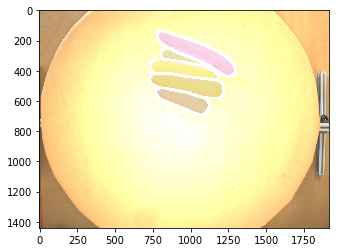

In [7]:
#check file
image_root = '../datasets/D2S/val2014/'
img_info = amodal.dataset['images'][100]
img = cv2.imread(os.path.join(image_root,img_info['file_name']))
annIds = amodal.getAmodalAnnIds(imgIds=img_info['id'])
anns = amodal.loadAnns(annIds)
ann = random.choice(anns)

img = img[:,:,[2,1,0]]
plt.imshow(img)
amodal.showAmodalAnns(ann) 

In [ ]:
#check file
image_root = '../datasets/D2S/val2014/'
for i in range(20):
    img_info = amodal.dataset['images'][i]
    img = cv2.imread(os.path.join(image_root,img_info['file_name']))
    annIds = amodal.getAmodalAnnIds(imgIds=img_info['id'])
    anns = amodal.loadAnns(annIds)

    img = img[:,:,[2,1,0]]
    plt.imshow(img)
    amodal.showAmodalAnns(anns[0]) 
    

    plt.savefig('./vis_d2s_gt/%s.png' %img_info['file_name'],dpi=200)
    plt.close()

True


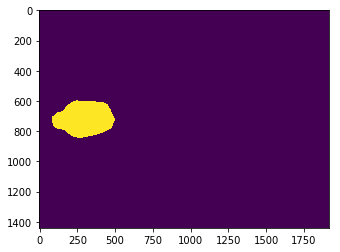

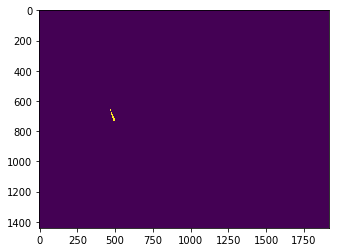

In [105]:
amodal_mask,invis_mask = amodal.getAmodalInstance(ann,img_info['width'],img_info['height'],3)
plt.imshow(amodal_mask)
plt.figure()
if len(invis_mask)>0:
    plt.imshow(invis_mask)

In [155]:
for i in range(len(amodal.dataset['images'])):
    img_info = amodal.dataset['images'][i]
    img_name = os.path.join(image_root,img_info['file_name'])
    
    cmd = 'mv ' + img_name + ' ' + '/home/anpei/segementation/pytorch-mask-rcnn-2/datasets/D2S/val/'
    os.system(cmd)

In [146]:
for i in range(len(amodal.dataset['images'])):
    img_info = amodal.dataset['images'][i]
    img_name = os.path.join(image_root,img_info['file_name'])
    #img = cv2.imread(img_name)
    annIds = amodal.getAmodalAnnIds(imgIds=img_info['id'])
    anns = amodal.loadAnns(annIds)
    
    occl_depth = []
    amodal_masks,vis_masks = [],[]
    for region in anns[0]['regions']:
        amodal_mask,vis_mask = amodal.getAnnMask2(region,img_info['width'],img_info['height'])
        amodal_masks.append(amodal_mask);vis_masks.append(vis_mask)
        #occl_depth.append(region['occl_depth'])
    labal = reLayerMask(vis_masks,amodal_masks)
    

    with open(img_name[:-4]+'.layer', 'wb') as fp:
        pickle.dump(labal, fp)